In [22]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
from scipy.spatial.distance import pdist, squareform


In [2]:
data = pd.read_csv('/Users/juliakahan/PycharmProjects/evo/ela_features_with_classes.csv')

In [3]:
X = data[['int', 'lr2', 'max', 'eps_ratio', 'disp', 'nbc']]

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#todo: investigate why the silhouette score is so low and try with removing outliers 

In [5]:
def plot_kmeans_silhouette(X, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title("Silhouette Score for K-Means Clustering")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.show()

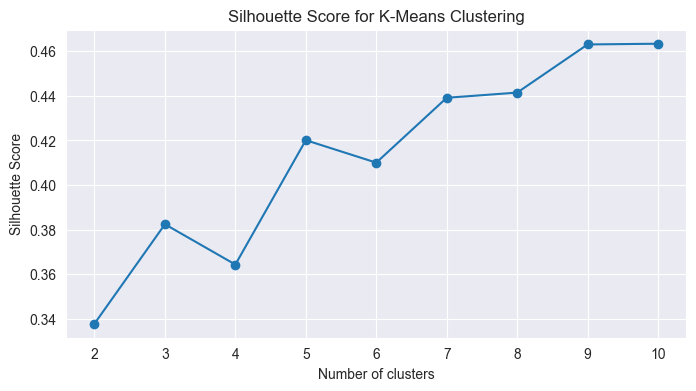

In [6]:
plot_kmeans_silhouette(X_scaled)

In [7]:
clustering_results_df = pd.DataFrame(columns=['Algorithm', 'Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'])


In [8]:
def evaluate_clustering(algorithm_name, labels, X_scaled):
    if len(set(labels)) > 1: 
        silhouette = silhouette_score(X_scaled, labels)
        davies_bouldin = davies_bouldin_score(X_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
    else:  #for DBSCAN, which can sometimes label everything as noise (-1)
        silhouette = davies_bouldin = calinski_harabasz = "N/A"
    return [algorithm_name, silhouette, davies_bouldin, calinski_harabasz]

In [24]:
def clustering_vis(labels, X_scaled, algorithm):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='rainbow', alpha=0.7)
    plt.title(f"{algorithm} Clustering Visualization (PCA)")
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.show()


In [9]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
evaluate_clustering('K-Means', kmeans_labels, X_scaled)
clustering_results_df.loc[0] = evaluate_clustering('K-Means', kmeans_labels, X_scaled)

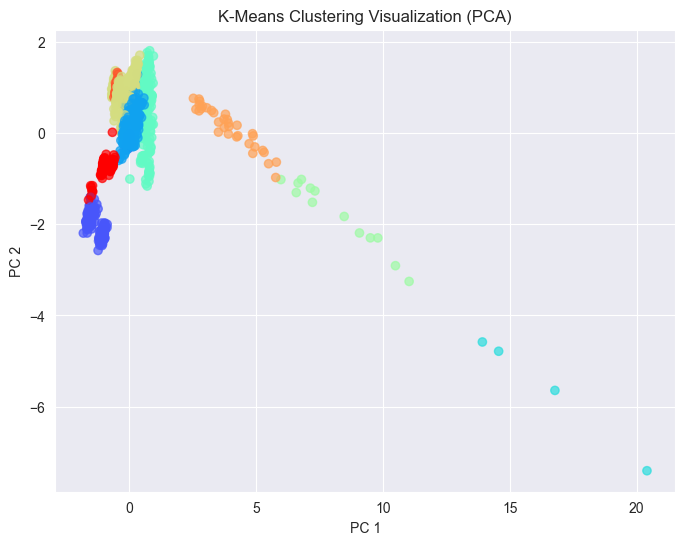

In [25]:
clustering_vis(kmeans_labels, X_scaled, 'K-Means')

In [10]:
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_clustering.fit_predict(X_scaled)
evaluate_clustering('Agglomerative', agg_labels, X_scaled)
clustering_results_df.loc[1] = evaluate_clustering('Agglomerative', agg_labels, X_scaled)

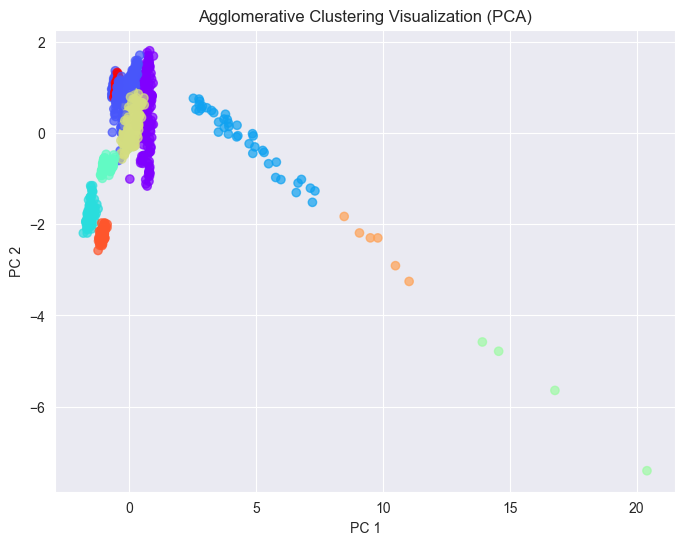

In [26]:
clustering_vis(agg_labels, X_scaled, 'Agglomerative')

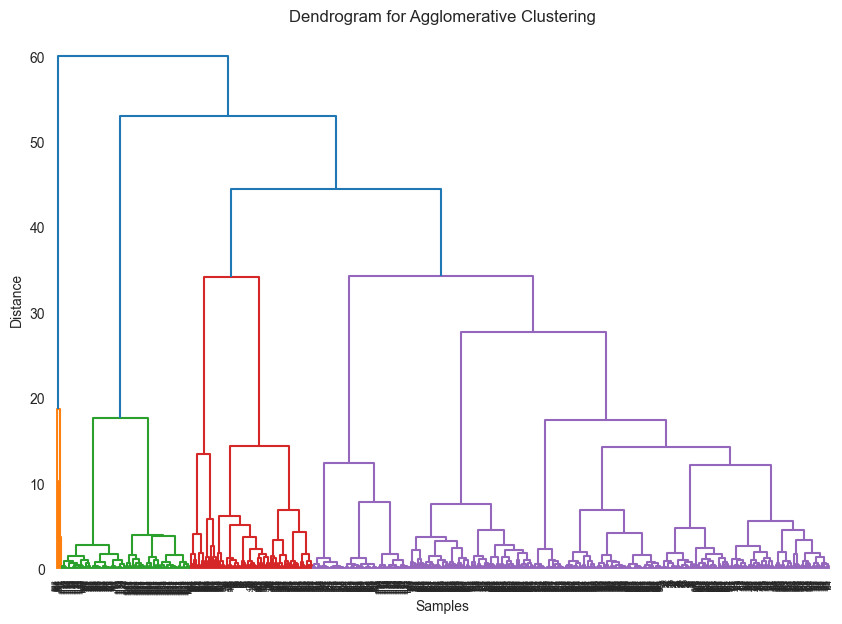

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10, 7))
Z = linkage(X_scaled, method='ward')
dendrogram(Z)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [11]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
evaluate_clustering('DBSCAN', dbscan_labels, X_scaled)
clustering_results_df.loc[2] = evaluate_clustering('DBSCAN', dbscan_labels, X_scaled)

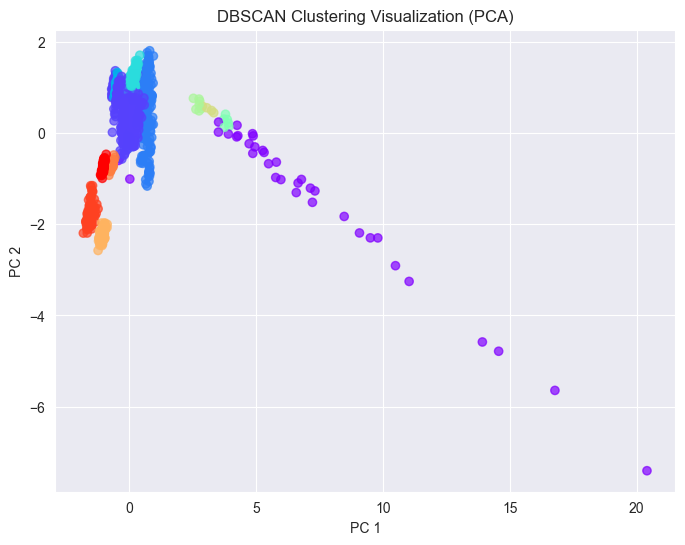

In [27]:
clustering_vis(dbscan_labels, X_scaled, 'DBSCAN')

In [29]:
clustering_results_df = pd.DataFrame(columns=['Algorithm', 'Num_Clusters', 'Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'])

def evaluate_clustering(algorithm_name, labels, X_scaled, num_clusters):
    """Evaluate clustering using several metrics and return the results as a list."""
    if len(set(labels)) > 1:
        silhouette = silhouette_score(X_scaled, labels)
        davies_bouldin = davies_bouldin_score(X_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
    else:  # e.g. for DBSCAN when all points are labeled noise
        silhouette = davies_bouldin = calinski_harabasz = "N/A"

    return [algorithm_name, num_clusters, silhouette, davies_bouldin, calinski_harabasz]

cluster_range = range(2, 11)

In [30]:
#KMeans and Agglomerative Clustering
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    clustering_results_df.loc[len(clustering_results_df)] = evaluate_clustering('K-Means', kmeans_labels, X_scaled, n_clusters)

    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg_clustering.fit_predict(X_scaled)
    clustering_results_df.loc[len(clustering_results_df)] = evaluate_clustering('Agglomerative', agg_labels, X_scaled, n_clusters)

In [31]:
#DBSCAN (Instead of varying clusters, vary the eps parameter)
eps_values = [0.3, 0.5, 0.7, 1.0]
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    clustering_results_df.loc[len(clustering_results_df)] = evaluate_clustering(f'DBSCAN (eps={eps})', dbscan_labels, X_scaled, 'N/A')

           Algorithm Num_Clusters  Silhouette  Davies-Bouldin  \
0            K-Means            2    0.337791        1.184968   
1      Agglomerative            2    0.801948        0.462484   
2            K-Means            3    0.382412        0.953155   
3      Agglomerative            3    0.376002        0.744770   
4            K-Means            4    0.364332        0.853771   
5      Agglomerative            4    0.405728        0.958089   
6            K-Means            5    0.420131        0.902089   
7      Agglomerative            5    0.413014        0.915789   
8            K-Means            6    0.410049        0.839963   
9      Agglomerative            6    0.435100        0.792697   
10           K-Means            7    0.439151        0.769235   
11     Agglomerative            7    0.437848        0.768822   
12           K-Means            8    0.441477        0.731502   
13     Agglomerative            8    0.437138        0.739523   
14           K-Means     

In [33]:
clustering_results_df

,Algorithm,Num_Clusters,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,K-Means,2,0.337791,1.184968,334.712433
1,Agglomerative,2,0.801948,0.462484,401.743721
2,K-Means,3,0.382412,0.953155,566.667239
3,Agglomerative,3,0.376002,0.744770,482.804997
4,K-Means,4,0.364332,0.853771,521.437872
5,Agglomerative,4,0.405728,0.958089,560.548987
6,K-Means,5,0.420131,0.902089,614.015207
7,Agglomerative,5,0.413014,0.915789,596.627985
8,K-Means,6,0.410049,0.839963,635.448762
9,Agglomerative,6,0.435100,0.792697,706.219257
